# To-Do List (Revised)

***Feature Engineering***
- Feature extraction
    - HOG (Done)
    - Landmarks(Done)
    - Gradients
- Class weighting (Done)
- Data normalization / standardization
- Augmentation

- Dimensionality reduction (PCA or selection for Fuzzy system)

***Models***
- SVM (Done)
- Random Forest
- MLP
- Fuzzy System (needs reduced feature set)

***Hyperparameter Tuning***

***Evaluation***
- Compute Accuracy + Balanced Accuracy
- Confusion Matrix (Validation + Test) for each model

***Comparison***
- Table comparing all models
- Discuss strengths / weaknesses / overfitting

***Real-Time Demo***
- Use only the best model
- Confirm correct model loading (joblib.load)
- Display predicted emotion labels

# Emotion Recognition Using HOG Features and SVM Classifier

This notebook implements facial emotion recognition using the FER2013 dataset.  
The process includes:
1. Data loading and preprocessing  
2. Handling class imbalance  
3. Extracting Histogram of Oriented Gradients (HOG) features  
4. Training a Support Vector Machine (SVM) classifier  
5. Evaluating the model on validation (PublicTest) and test (PrivateTest) sets  
6. Visualizing results (class imbalance, HOG features, confusion matrices)  
7. Running a real-time emotion detection demo using OpenCV

In [7]:
import pandas as pd
import numpy as np
import os
import joblib
import cv2
import seaborn as sns
import random
import time
import matplotlib.pyplot as plt
import mediapipe as mp


from joblib import Parallel, delayed
from itertools import product
from pathlib import Path
from tqdm import tqdm
from skimage import exposure
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)


## 1. Data Loading and Splitting
The FER2013 dataset contains 48×48 grayscale facial images,
each labeled with one of seven emotion categories:
0–6 → [angry, disgust, fear, happy, sad, surprise, neutral].

The dataset provides three splits:
- Training (fit the model)
- PublicTest (validation for hyperparameter tuning)
- PrivateTest (final test for generalization)

Train size: 28709
Validation size: 3589
Test size: 3589

In [8]:
# Read FER2013 dataset
df = pd.read_csv("data/fer2013.csv")

# Split data by Usage column
train_df = df[df["Usage"] == "Training"].copy()
val_df   = df[df["Usage"] == "PublicTest"].copy()
test_df  = df[df["Usage"] == "PrivateTest"].copy()

# Emotion label mapping
emotion_labels = {
    0: "angry", 1: "disgust", 2: "fear",
    3: "happy", 4: "sad", 5: "surprise", 6: "neutral"
}

# Display dataset sizes
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 28709
Validation size: 3589
Test size: 3589


## 2. Preprocessing
Each sample in the dataset is stored as a string of pixel values.  
These steps convert the strings to 48×48 grayscale arrays and normalize them to the range [0, 1].

In [9]:
# Convert pixel strings to 48×48 arrays and normalize
def pixels_to_array(series):
    """Convert pixel strings to normalized 48×48 float arrays."""
    return np.vstack([np.fromstring(x, sep=' ') for x in series]).reshape(-1, 48, 48) / 255.0

X_train = pixels_to_array(train_df["pixels"])
X_val   = pixels_to_array(val_df["pixels"])
X_test  = pixels_to_array(test_df["pixels"])

y_train = train_df["emotion"].values
y_val   = val_df["emotion"].values
y_test  = test_df["emotion"].values

### Skip it
### Define canonical geometry for aligned 48×48 faces

The goal is to place both eyes at approximately 35% of the image height,  
and the mouth center at approximately 70% of the image height in the aligned output.

In [10]:
'''
W, H = 48, 48
DST_LEFT_EYE  = np.array([0.30 * W, 0.35 * H], dtype=np.float32)
DST_RIGHT_EYE = np.array([0.70 * W, 0.35 * H], dtype=np.float32)
DST_MOUTH     = np.array([0.50 * W, 0.70 * H], dtype=np.float32)
DST_TRI = np.stack([DST_LEFT_EYE, DST_RIGHT_EYE, DST_MOUTH]).astype(np.float32)

# Facial landmark indices for approximate eye/mouth centers
# (Mediapipe FaceMesh has 468 points)
LEFT_EYE_IDXS  = [33, 133, 159, 145, 153]     # Left eye region (outer + inner corners, upper/lower lids)
RIGHT_EYE_IDXS = [362, 263, 386, 374, 380]    # Right eye region (outer + inner corners, upper/lower lids)
MOUTH_IDXS     = [61, 291, 0, 17, 13]         # Mouth region (corners, upper/lower midpoints)

mp_face_mesh = mp.solutions.face_mesh

# Utility: compute the average 2D location of a given landmark group
def _part_center(landmarks_xy, idxs, img_w, img_h):
    pts = np.array([[landmarks_xy[i].x * img_w, landmarks_xy[i].y * img_h] for i in idxs], dtype=np.float32)
    return pts.mean(axis=0)

# Align a single 48×48 grayscale image using three facial points
def align_face(img48_float01, target_size=(48, 48)):
    """
    Perform face alignment using Mediapipe FaceMesh.
    Each call creates a new FaceMesh instance (safe for multiprocessing).
    """
    up_w = up_h = max(96, target_size[0] * 2)
    img_u8 = (img48_float01 * 255).astype(np.uint8)
    big = cv2.resize(img_u8, (up_w, up_h), interpolation=cv2.INTER_CUBIC)
    rgb = cv2.cvtColor(big, cv2.COLOR_GRAY2RGB)

    with mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as fm:
        res = fm.process(rgb)
        if not res.multi_face_landmarks:
            return img48_float01, False

        lm = res.multi_face_landmarks[0].landmark
        try:
            le = _part_center(lm, LEFT_EYE_IDXS,  up_w, up_h)
            re = _part_center(lm, RIGHT_EYE_IDXS, up_w, up_h)
            mo = _part_center(lm, MOUTH_IDXS,     up_w, up_h)
            src_tri = np.stack([le, re, mo]).astype(np.float32)
            # Compute affine transform
            M = cv2.getAffineTransform(src_tri, DST_TRI * 2)  # upscale target to match 96×96
            warped_full = cv2.warpAffine(
                big, M, (96, 96),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_REFLECT_101
            )

            # Crop the central 48×48 region
            center_crop = warped_full[24:72, 24:72]

            # Convert back to float [0,1]
            return (center_crop.astype(np.float32) / 255.0), True

        except Exception:
            # Any error → return original
            return img48_float01, False
# Parallel face alignment for entire dataset + save to disk
def align_batch_parallel(X48_float01, n_jobs=-1, prefix="train"):
    """
    Parallel batch alignment. Each process creates its own FaceMesh instance
    (cannot share due to non-picklable Mediapipe object).
    """
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(align_face)(img) for img in X48_float01
    )

    X_aligned, success_mask = zip(*results)
    X_aligned = np.array(X_aligned, dtype=np.float32)
    success_mask = np.array(success_mask, dtype=bool)

    os.makedirs("features", exist_ok=True)
    np.save(f"features/X_{prefix}_aligned.npy", X_aligned)
    np.save(f"features/ok_{prefix}.npy", success_mask)

    print(f"\n[{prefix.upper()}] Alignment complete.")
    print(f"Success rate: {success_mask.mean() * 100:.2f}%")
    print(f"Saved to: features/X_{prefix}_aligned.npy")

    return X_aligned, success_mask
'''

'''
X_train_aligned, ok_train = align_batch_parallel(X_train, prefix="train")
X_val_aligned,   ok_val   = align_batch_parallel(X_val,   prefix="val")
X_test_aligned,  ok_test  = align_batch_parallel(X_test,  prefix="test")

print(f"[Train] Success rate: {ok_train.mean() * 100:.2f}%")
print(f"[Val]   Success rate: {ok_val.mean() * 100:.2f}%")
print(f"[Test]  Success rate: {ok_test.mean() * 100:.2f}%")
'''



'\nX_train_aligned, ok_train = align_batch_parallel(X_train, prefix="train")\nX_val_aligned,   ok_val   = align_batch_parallel(X_val,   prefix="val")\nX_test_aligned,  ok_test  = align_batch_parallel(X_test,  prefix="test")\n\nprint(f"[Train] Success rate: {ok_train.mean() * 100:.2f}%")\nprint(f"[Val]   Success rate: {ok_val.mean() * 100:.2f}%")\nprint(f"[Test]  Success rate: {ok_test.mean() * 100:.2f}%")\n'

In [11]:
'''
def visualize_per_emotion(X_original, X_aligned, success_mask, y_labels, emotion_labels, n=3, title="Validation"):
    """
    Visualize samples per emotion label (original vs aligned).
    Each row corresponds to one emotion category.
    Each column shows randomly selected examples.
    """
    unique_labels = sorted(emotion_labels.keys())
    rows = len(unique_labels)
    cols = n
    fig, axes = plt.subplots(rows * 2, cols, figsize=(2 * cols, 3.5 * rows))

    for r, lbl in enumerate(unique_labels):
        label_name = emotion_labels[lbl]
        # Find samples belonging to this emotion
        indices = np.where(y_labels == lbl)[0]
        if len(indices) == 0:
            continue

        # Randomly select up to n samples
        chosen = np.random.choice(indices, size=min(n, len(indices)), replace=False)

        for c, i in enumerate(chosen):
            # --- Original image ---
            ax_orig = axes[2 * r, c]
            ax_orig.imshow(X_original[i], cmap='gray')
            ax_orig.axis('off')
            ax_orig.set_title(f"{label_name}", fontsize=9, color="black")

            # --- Aligned image ---
            ax_align = axes[2 * r + 1, c]
            ax_align.imshow(X_aligned[i], cmap='gray')
            status = "Aligned" if success_mask[i] else "Failed"
            color = "green" if success_mask[i] else "red"
            ax_align.set_title(status, fontsize=8, color=color)
            ax_align.axis('off')

        # Add left-side label for row
        axes[2 * r, 0].set_ylabel(f"{label_name}\n(Original)", fontsize=10)
        axes[2 * r + 1, 0].set_ylabel(f"{label_name}\n(Aligned)", fontsize=10)

    plt.suptitle(f"{title} Set – Per Emotion Alignment", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


'''

'\ndef visualize_per_emotion(X_original, X_aligned, success_mask, y_labels, emotion_labels, n=3, title="Validation"):\n    """\n    Visualize samples per emotion label (original vs aligned).\n    Each row corresponds to one emotion category.\n    Each column shows randomly selected examples.\n    """\n    unique_labels = sorted(emotion_labels.keys())\n    rows = len(unique_labels)\n    cols = n\n    fig, axes = plt.subplots(rows * 2, cols, figsize=(2 * cols, 3.5 * rows))\n\n    for r, lbl in enumerate(unique_labels):\n        label_name = emotion_labels[lbl]\n        # Find samples belonging to this emotion\n        indices = np.where(y_labels == lbl)[0]\n        if len(indices) == 0:\n            continue\n\n        # Randomly select up to n samples\n        chosen = np.random.choice(indices, size=min(n, len(indices)), replace=False)\n\n        for c, i in enumerate(chosen):\n            # --- Original image ---\n            ax_orig = axes[2 * r, c]\n            ax_orig.imshow(X_origi

In [12]:
'''
visualize_per_emotion(
    X_val,              # original validation images
    X_val_aligned,      # aligned validation images
    ok_val,             # success mask
    y_val,              # integer emotion labels
    emotion_labels,     # {0:'angry', 1:'disgust', ...}
    n=3,                # show 3 samples per emotion
    title="Validation"
)

'''

'\nvisualize_per_emotion(\n    X_val,              # original validation images\n    X_val_aligned,      # aligned validation images\n    ok_val,             # success mask\n    y_val,              # integer emotion labels\n    emotion_labels,     # {0:\'angry\', 1:\'disgust\', ...}\n    n=3,                # show 3 samples per emotion\n    title="Validation"\n)\n\n'

## HOG Feature Extraction Overview
HOG (Histogram of Oriented Gradients) captures edge and texture information instead of raw pixel intensity.  
Each 48×48 image is divided into 8×8 cells. Gradients are computed per cell and normalized over 2×2 cell blocks (16×16 pixel area).  
The concatenated histograms form a 1D feature vector that represents the image structure.

All HOG features saved to /features/

Train: (28709, 900)

Val:   (3589, 900)

Test:  (3589, 900)



In [13]:
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), n_jobs=-1, desc="Extracting HOG"):
    """
    Compute HOG (Histogram of Oriented Gradients) features for each image.
    Runs in parallel using all CPU cores by default.

    Parameters
    ----------
    images : np.ndarray
        Grayscale input images (N, 48, 48), normalized to [0, 1].
    pixels_per_cell : tuple
        Size (in pixels) of each cell for gradient computation.
    cells_per_block : tuple
        Number of cells per normalization block.
    n_jobs : int
        Number of CPU cores to use (-1 = all).
    desc : str
        Progress bar description for tqdm.

    Returns
    -------
    np.ndarray
        Array of HOG feature vectors (N, n_features).
    """
    start_time = time.time()
    #print(f"\n[{desc}]")
    
    # Parallel computation of HOG per image
    features = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(hog)(
            img,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            feature_vector=True
        )
        for img in tqdm(images, desc=desc)
    )

    features = np.array(features, dtype=np.float32)
    elapsed = time.time() - start_time
    print("+++++++++++")
    print(f"Done: {features.shape}  (Elapsed: {elapsed:.2f} sec)")
    print("+++++++++++")
    return features



In [14]:
# Create output directory for saved feature files
os.makedirs("features", exist_ok=True)

# Extract HOG features for each dataset split
X_train_hog = extract_hog_features(X_train, desc="Training Set HOG")
X_val_hog   = extract_hog_features(X_val,   desc="Validation Set HOG")
X_test_hog  = extract_hog_features(X_test,  desc="Test Set HOG")

# Save extracted features to disk
np.save("features/X_train_hog.npy", X_train_hog)
np.save("features/X_val_hog.npy", X_val_hog)
np.save("features/X_test_hog.npy", X_test_hog)

print("\nAll HOG features saved to /features/")
print("Train:", X_train_hog.shape)
print("Val:  ", X_val_hog.shape)
print("Test: ", X_test_hog.shape)

Training Set HOG:   0%|          | 16/28709 [00:02<1:28:03,  5.43it/s][Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17201792100753396s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.006780147552490234s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007898807525634766s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.01240396499633789s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 160 tasks      | el

+++++++++++
Done: (28709, 900)  (Elapsed: 6.29 sec)
+++++++++++


Validation Set HOG:   0%|          | 0/3589 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0017542839050292969s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.006804943084716797s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.008375167846679688s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.010031938552856445s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation

+++++++++++
Done: (3589, 900)  (Elapsed: 0.48 sec)
+++++++++++


Test Set HOG:   0%|          | 0/3589 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0015859603881835938s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.00650787353515625s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.00528407096862793s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.00811314582824707s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast

+++++++++++
Done: (3589, 900)  (Elapsed: 0.41 sec)
+++++++++++

All HOG features saved to /features/
Train: (28709, 900)
Val:   (3589, 900)
Test:  (3589, 900)


# Landmark Features
Facial landmark features provide a structured and geometry-based representation of facial expressions, focusing on the relative positions and movements of key facial regions such as the eyes, eyebrows, nose, and mouth.
Unlike pixel-based or gradient-based methods (such as HOG), landmark features explicitly encode the shape and configuration of the face, which are highly informative for emotion recognition tasks.

Motivation

While Histogram of Oriented Gradients (HOG) captures local texture and edge orientation patterns, it lacks explicit information about facial geometry. Emotions such as happiness or sadness are often expressed through subtle geometric changes — for example:
	•	The upward curvature of the mouth for happiness
	•	The downward tilt of the eyebrows for sadness
	•	The widening of the eyes for surprise

Facial landmarks can represent these changes directly by quantifying the spatial displacement of key facial points.

Implementation

This project uses Mediapipe FaceMesh, which detects 468 3D facial landmarks on each image.
Only the 2D normalized (x, y) coordinates are extracted to form a flattened feature vector of size 468 × 2 = 936.
Each feature vector captures the facial structure in a way that is invariant to lighting or minor pixel noise.

If the face is not detected in an image, a zero vector is substituted to maintain consistent dimensionality.

Advantages
	•	Interpretable: Features correspond to meaningful facial parts (eyes, nose, mouth).
	•	Compact: Uses geometric information instead of raw pixel data.
	•	Complementary: Can be combined with texture-based descriptors (e.g., HOG) to improve recognition accuracy.
	•	Robust: Less sensitive to illumination changes and background clutter.

Summary

Landmark features serve as a structural descriptor that complements the texture-based information from HOG.
By combining both feature types, the model gains a richer understanding of facial expression—capturing not only how the face looks (edges/textures) but also how it moves and deforms (geometry).

All landmark features saved to /features/

Train: (28709, 936)

Val:   (3589, 936)

Test:  (3589, 936)

In [15]:
def extract_landmark_features(images, resize=(96, 96), verbose=True):
    """
    Extract 2D facial landmark coordinates (x, y) for each image using Mediapipe FaceMesh.

    Parameters
    ----------
    images : np.ndarray
        Input grayscale images (N, 48, 48), normalized to [0,1].
    resize : tuple(int, int)
        Upscaled size for better landmark detection (default = 96x96).
    verbose : bool
        Whether to print summary statistics after processing.

    Returns
    -------
    features : np.ndarray
        Array of shape (N, 468*2) containing flattened (x, y) coordinates.
    success_mask : np.ndarray
        Boolean array of successful detections.
    """
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

    features = []
    success_mask = []

    for img in tqdm(images, desc="Landmark Extraction"):
        # Convert grayscale [0,1] image to uint8 RGB
        img_resized = cv2.resize((img * 255).astype('uint8'), resize)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

        # Run Mediapipe FaceMesh
        result = face_mesh.process(img_rgb)

        if result.multi_face_landmarks:
            landmarks = result.multi_face_landmarks[0]
            coords = np.array([[lm.x, lm.y] for lm in landmarks.landmark])

            # Apply stabilization to reduce drift
            #coords = stabilize_landmarks(coords)

            # Flatten for saving
            coords = coords.flatten()
            success_mask.append(True)
        else:
            coords = np.zeros(468 * 2)
            success_mask.append(False)

        features.append(coords)

    face_mesh.close()
    features = np.array(features, dtype=np.float32)
    success_mask = np.array(success_mask, dtype=bool)

    if verbose:
        total = len(images)
        print(f"Detected faces in {success_mask.sum()}/{total} images "
              f"({success_mask.mean() * 100:.2f}% success rate)")

    return features, success_mask

In [16]:
def stabilize_landmarks(coords):
    """
    Normalize and stabilize landmark geometry by centering and rescaling.
    Prevents large positional drift caused by low-res images.
    """
    if np.allclose(coords, 0):
        return coords

    # Center to mean position
    mean = coords.mean(axis=0)
    coords_centered = coords - mean

    # Normalize global scale (not per axis)
    scale = np.linalg.norm(coords_centered.std(axis=0))
    if scale > 0:
        coords_centered /= scale

    # Shift back to roughly [0,1] range without altering shape
    coords_stable = coords_centered - coords_centered.min(axis=0)
    coords_stable /= coords_stable.max(axis=0)

    return coords_stable

In [17]:
# Detect invalid landmark sets (corner clustering or zeros)
def detect_invalid_landmarks(coords, threshold_ratio=0.05):
    """
    Detect invalid landmark sets that collapse near the image corner or contain all zeros.

    Parameters
    ----------
    coords : np.ndarray
        (468, 2) landmark coordinates normalized to [0,1].
    threshold_ratio : float
        Threshold ratio relative to image size; if all landmarks are clustered near (0,0)
        within this ratio, the sample is marked invalid.

    Returns
    -------
    bool : True if invalid (collapsed or zero landmarks)
    """
    if np.allclose(coords, 0):
        return True

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # bounding box too small or stuck near top-left
    if (x_max - x_min) < threshold_ratio and (y_max - y_min) < threshold_ratio:
        return True
    if (x_max < threshold_ratio and y_max < threshold_ratio):
        return True

    return False


In [18]:
# Summarize four detection states (Sucess/ failed)
def summarize_landmark_states(ok_mask, valid_mask, y_labels, emotion_labels):
    """
    Summarize landmark detection results (Success vs Failure) overall and per emotion.

    Parameters
    ----------
    ok_mask : np.ndarray
        Boolean array from Mediapipe (True if face detected).
    valid_mask : np.ndarray
        Boolean array marking valid landmark configurations.
    y_labels : np.ndarray
        Integer emotion labels.
    emotion_labels : dict
        Mapping {0:'angry', 1:'disgust', ...}.

    Returns
    -------
    pd.DataFrame
        Summary table containing per-emotion and overall success/failure counts and rates.
    """
    summary_rows = []
    emotions = sorted(emotion_labels.keys())

    for lbl in emotions:
        name = emotion_labels[lbl]
        idx = np.where(y_labels == lbl)[0]
        if len(idx) == 0:
            continue

        ok = ok_mask[idx]
        val = valid_mask[idx]

        # Define success/failure
        success = np.sum(ok & val)
        fail = np.sum(~(ok & val))
        total = len(idx)

        summary_rows.append({
            "Emotion": name,
            "Success": success,
            "Failure": fail,
            "Total": total,
            "Success %": round(100 * success / total, 1),
            "Failure %": round(100 * fail / total, 1)
        })

    # Compute overall statistics
    df_summary = pd.DataFrame(summary_rows)
    df_summary.loc["Overall"] = df_summary.iloc[:, 1:].sum()
    df_summary.loc["Overall", "Emotion"] = "Overall"
    total_all = df_summary.loc["Overall", "Total"]
    df_summary.loc["Overall", ["Success %", "Failure %"]] = [
        round(100 * df_summary.loc["Overall", k] / total_all, 1)
        for k in ["Success", "Failure"]
    ]

    return df_summary

In [19]:
def visualize_landmark_states(
    X_images, X_landmarks, ok_mask, valid_mask,
    y_labels, emotion_labels, n_per_state=3,
    title="Landmark Detection – Success vs Failure",
    seed=42   
):
    """
    Visualize landmark detection success and failure per emotion.
    """
    # Set reproducible random seed
    np.random.seed(seed)

    # Define success vs failure
    success_mask = ok_mask & valid_mask
    fail_mask = ~success_mask

    states = [
        ("Success", success_mask, "green"),
        ("Failure", fail_mask, "red")
    ]

    unique_labels = sorted(emotion_labels.keys())
    rows = len(unique_labels)
    cols = len(states) * n_per_state
    fig, axes = plt.subplots(rows, cols, figsize=(2.3 * cols, 2.5 * rows))

    if rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, lbl in enumerate(unique_labels):
        emotion_name = emotion_labels[lbl]

        for s, (label, mask, color) in enumerate(states):
            idx_candidates = np.where((y_labels == lbl) & (mask == True))[0]
            if len(idx_candidates) == 0:
                continue

            chosen = np.random.choice(idx_candidates, size=min(n_per_state, len(idx_candidates)), replace=False)

            for c, i in enumerate(chosen):
                ax = axes[r, s * n_per_state + c]
                ax.imshow(X_images[i], cmap='gray')
                coords = X_landmarks[i].reshape(-1, 2)
                ax.scatter(coords[:, 0] * 48, coords[:, 1] * 48, s=5, c=color, alpha=0.6)
                ax.axis('off')
                ax.set_title(label, color=color, fontsize=9)

        axes[r, 0].set_ylabel(emotion_name, fontsize=10, rotation=0,
                              labelpad=30, color="black", weight="bold")

    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

In [20]:
# Extract features
X_val_landmark, ok_val     = extract_landmark_features(X_val)

X_train_landmark, ok_train = extract_landmark_features(X_train)

X_test_landmark, ok_test   = extract_landmark_features(X_test)

# Save extracted features
os.makedirs("features", exist_ok=True)
np.save("features/X_train_landmark.npy", X_train_landmark)
np.save("features/X_val_landmark.npy", X_val_landmark)
np.save("features/X_test_landmark.npy", X_test_landmark)


print("\nAll landmark features saved to /features/")
print("Train:", X_train_landmark.shape)
print("Val:  ", X_val_landmark.shape)
print("Test: ", X_test_landmark.shape)

Landmark Extraction: 100%|██████████| 3589/3589 [00:22<00:00, 156.05it/s]


Detected faces in 3276/3589 images (91.28% success rate)


Landmark Extraction: 100%|██████████| 28709/28709 [03:03<00:00, 156.37it/s]


Detected faces in 26271/28709 images (91.51% success rate)


Landmark Extraction: 100%|██████████| 3589/3589 [00:22<00:00, 159.39it/s]


Detected faces in 3283/3589 images (91.47% success rate)

All landmark features saved to /features/
Train: (28709, 936)
Val:   (3589, 936)
Test:  (3589, 936)


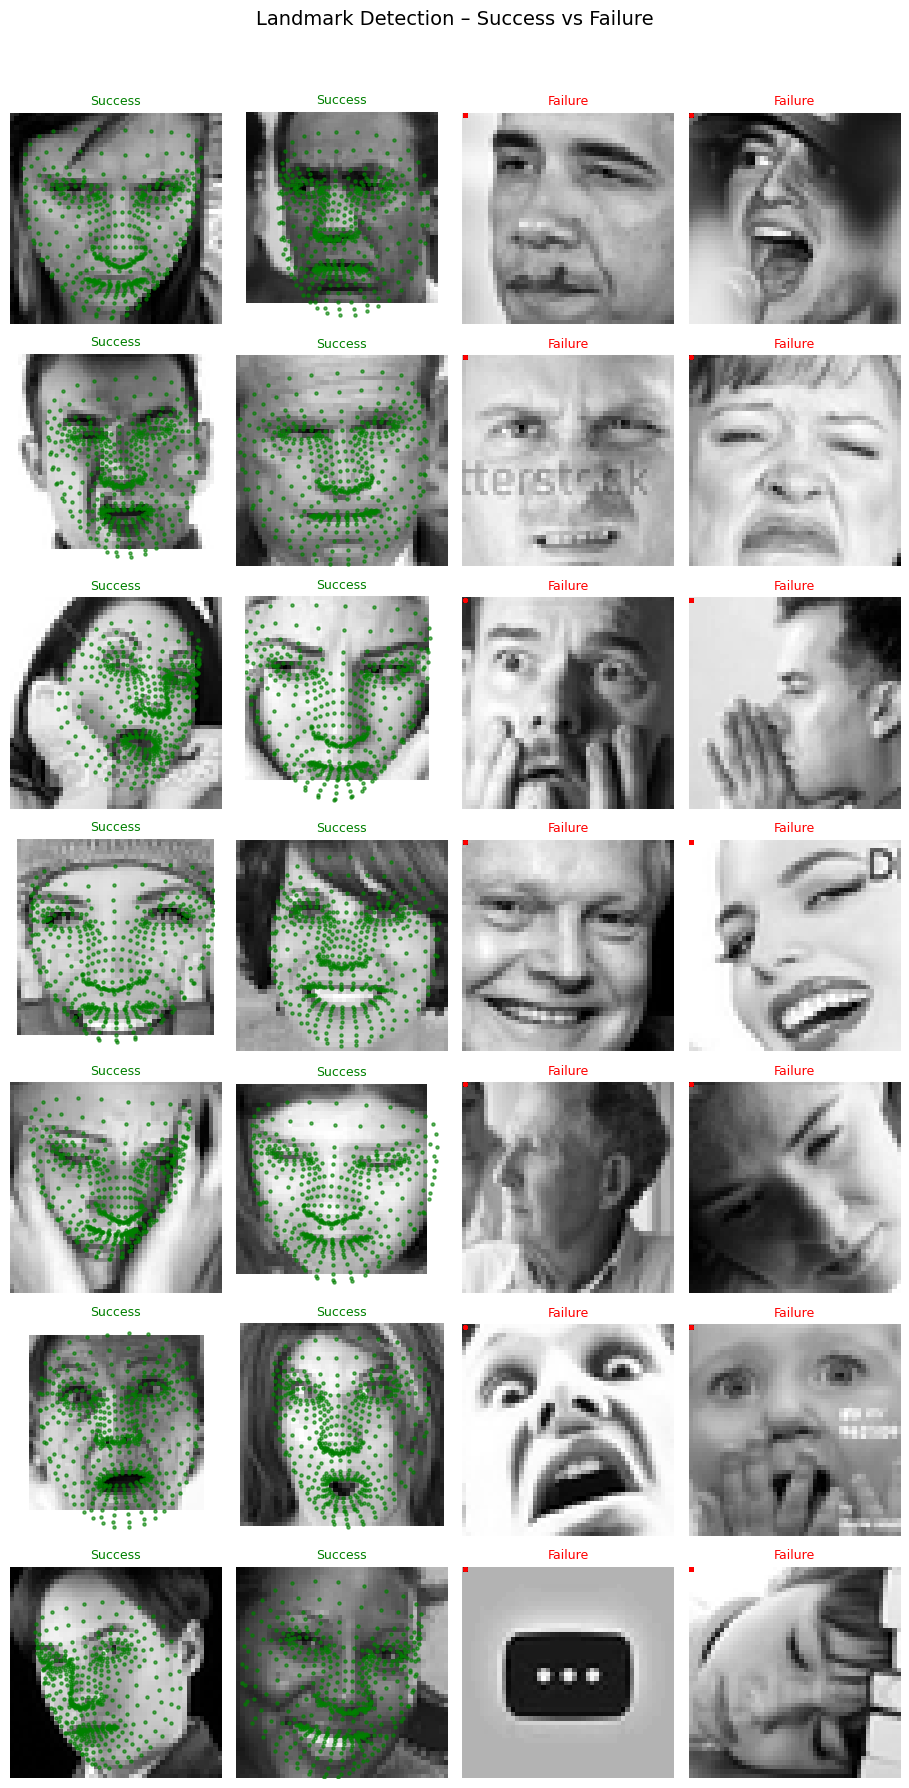

In [21]:
# Detect invalid landmark sets for all splits
invalid_mask_train = np.array([
    detect_invalid_landmarks(X_train_landmark[i].reshape(-1, 2))
    for i in range(len(X_train_landmark))
])
invalid_mask_val = np.array([
    detect_invalid_landmarks(X_val_landmark[i].reshape(-1, 2))
    for i in range(len(X_val_landmark))
])
invalid_mask_test = np.array([
    detect_invalid_landmarks(X_test_landmark[i].reshape(-1, 2))
    for i in range(len(X_test_landmark))
])

# Convert to valid masks (True = usable landmark)
valid_mask_train = ~invalid_mask_train
valid_mask_val   = ~invalid_mask_val
valid_mask_test  = ~invalid_mask_test

ok_train = ok_train.astype(bool); valid_mask_train = valid_mask_train.astype(bool)
ok_val   = ok_val.astype(bool);   valid_mask_val   = valid_mask_val.astype(bool)
ok_test  = ok_test.astype(bool);  valid_mask_test  = valid_mask_test.astype(bool)

df_train = summarize_landmark_states(ok_train, valid_mask_train, y_train, emotion_labels)
df_val   = summarize_landmark_states(ok_val,   valid_mask_val,   y_val,   emotion_labels)
df_test  = summarize_landmark_states(ok_test,  valid_mask_test,  y_test,  emotion_labels)


# Visualize landmark states
visualize_landmark_states(
    X_train, X_train_landmark,
    ok_train, valid_mask_train,
    y_train, emotion_labels,
    n_per_state=2,
    seed=2025
)


=== TRAIN SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,3467.0,528.0,3995.0,86.8,13.2
1,disgust,363.0,73.0,436.0,83.3,16.7
2,fear,3612.0,485.0,4097.0,88.2,11.8
3,happy,6881.0,334.0,7215.0,95.4,4.6
4,sad,4209.0,621.0,4830.0,87.1,12.9
5,surprise,2982.0,189.0,3171.0,94.0,6.0
6,neutral,4757.0,208.0,4965.0,95.8,4.2
Overall,Overall,26271.0,2438.0,28709.0,91.5,8.5



=== VALIDATION SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,412.0,55.0,467.0,88.2,11.8
1,disgust,51.0,5.0,56.0,91.1,8.9
2,fear,444.0,52.0,496.0,89.5,10.5
3,happy,864.0,31.0,895.0,96.5,3.5
4,sad,546.0,107.0,653.0,83.6,16.4
5,surprise,380.0,35.0,415.0,91.6,8.4
6,neutral,579.0,28.0,607.0,95.4,4.6
Overall,Overall,3276.0,313.0,3589.0,91.3,8.7



=== TEST SET ===


,Emotion,Success,Failure,Total,Success %,Failure %
0,angry,422.0,69.0,491.0,85.9,14.1
1,disgust,46.0,9.0,55.0,83.6,16.4
2,fear,467.0,61.0,528.0,88.4,11.6
3,happy,842.0,37.0,879.0,95.8,4.2
4,sad,518.0,76.0,594.0,87.2,12.8
5,surprise,388.0,28.0,416.0,93.3,6.7
6,neutral,600.0,26.0,626.0,95.8,4.2
Overall,Overall,3283.0,306.0,3589.0,91.5,8.5


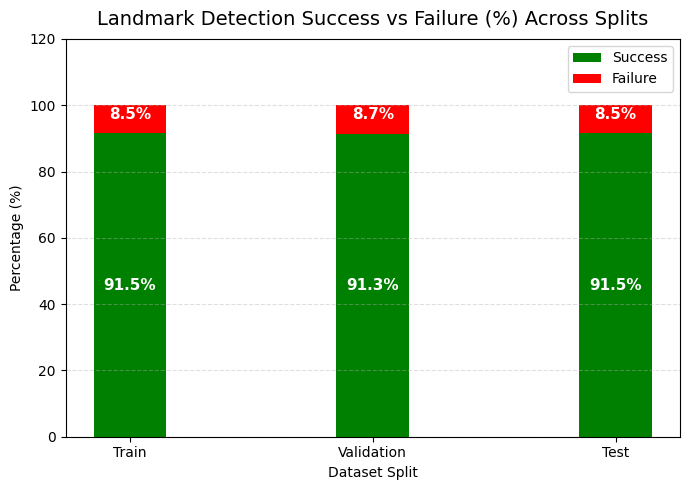

,Split,Success %,Failure %,Total
0,Train,91.507890,8.492110,28709.0
1,Validation,91.278908,8.721092,3589.0
2,Test,91.473948,8.526052,3589.0


In [22]:
print("=== TRAIN SET ===")
display(df_train[["Emotion","Success","Failure","Total","Success %","Failure %"]])

print("\n=== VALIDATION SET ===")
display(df_val[["Emotion","Success","Failure","Total","Success %","Failure %"]])

print("\n=== TEST SET ===")
display(df_test[["Emotion","Success","Failure","Total","Success %","Failure %"]])

# Prepare summary DataFrame (Overall rows only)
summary_overall = pd.DataFrame({
    "Split": ["Train", "Validation", "Test"],
    "Success": [
        df_train.loc["Overall", "Success"],
        df_val.loc["Overall", "Success"],
        df_test.loc["Overall", "Success"]
    ],
    "Failure": [
        df_train.loc["Overall", "Failure"],
        df_val.loc["Overall", "Failure"],
        df_test.loc["Overall", "Failure"]
    ]
})

# Convert counts → percentages
summary_overall["Total"] = summary_overall["Success"] + summary_overall["Failure"]
summary_overall["Success %"] = (summary_overall["Success"] / summary_overall["Total"]) * 100
summary_overall["Failure %"] = (summary_overall["Failure"] / summary_overall["Total"]) * 100

# Prepare data
splits = summary_overall["Split"]
success = summary_overall["Success %"]
failure = summary_overall["Failure %"]

# Plot stacked bar chart
plt.figure(figsize=(7, 5))
bar_width = 0.3
plt.bar(splits, success, color="green", width=bar_width, label="Success")
plt.bar(splits, failure, bottom=success, color="red", width=bar_width, label="Failure")

# Adjust label placement to avoid overlap ===
for i, (suc, fail) in enumerate(zip(success, failure)):
    # Success label 
    plt.text(i, suc * 0.5, f"{suc:.1f}%", ha="center", va="center",
             color="white", fontsize=11, weight="bold")

    # Failure label
    plt.text(i, suc + fail * 0.5 + 1.5, f"{fail:.1f}%", ha="center", va="center",
             color="white", fontsize=11, weight="bold")

# Aesthetics
plt.title("Landmark Detection Success vs Failure (%) Across Splits", fontsize=14, pad=10)
plt.ylabel("Percentage (%)")
plt.xlabel("Dataset Split")
plt.ylim(0, 120)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend(title="", loc="upper right")
plt.tight_layout()
plt.show()

# Display table below
display(summary_overall[["Split", "Success %", "Failure %", "Total"]])

# Combine HOG and Landmark Features

The concatenation of HOG (texture) and landmarks (geometry) gives a hybrid representation that improves robustness and recognition accuracy.

Train combined shape: (26271, 1836)

Val combined shape: (3276, 1836)

Test combined shape: (3283, 1836)


In [23]:
# === Load saved HOG features ===
X_train_hog = np.load("features/X_train_hog.npy")
X_val_hog   = np.load("features/X_val_hog.npy")
X_test_hog  = np.load("features/X_test_hog.npy")

# === Select only valid landmark detections ===
valid_idx_train = np.where(ok_train & valid_mask_train)[0]
valid_idx_val   = np.where(ok_val   & valid_mask_val)[0]
valid_idx_test  = np.where(ok_test  & valid_mask_test)[0]

# === Subset data ===
X_train_hog_valid      = X_train_hog[valid_idx_train]
X_val_hog_valid        = X_val_hog[valid_idx_val]
X_test_hog_valid       = X_test_hog[valid_idx_test]

X_train_landmark_valid = X_train_landmark[valid_idx_train]
X_val_landmark_valid   = X_val_landmark[valid_idx_val]
X_test_landmark_valid  = X_test_landmark[valid_idx_test]

y_train_valid = y_train[valid_idx_train]
y_val_valid   = y_val[valid_idx_val]
y_test_valid  = y_test[valid_idx_test]

# === Concatenate HOG + Landmark features ===
X_train_combined = np.hstack([X_train_hog_valid, X_train_landmark_valid])
X_val_combined   = np.hstack([X_val_hog_valid,   X_val_landmark_valid])
X_test_combined  = np.hstack([X_test_hog_valid,  X_test_landmark_valid])

print("Train combined shape:", X_train_combined.shape)
print("Val combined shape:",   X_val_combined.shape)
print("Test combined shape:",  X_test_combined.shape)

Train combined shape: (26271, 1836)
Val combined shape: (3276, 1836)
Test combined shape: (3283, 1836)


## Handling Data Imbalance

The FER2013 dataset presents a significant **class imbalance** across emotion categories.  
Certain emotions such as happy and neutral have a large number of samples, while others such as *disgust* and *fear* are severely underrepresented.  

This imbalance causes the model to become biased toward majority classes, resulting in:
- High overall accuracy but poor recall for rare emotions  
- Misclassification of subtle or less common expressions  
- Reduced robustness when recognizing diverse emotional patterns  

Visual inspection of the dataset confirms that the distribution of emotion samples is uneven, making imbalance correction an essential step before model training.

## Class Weights

To mitigate the imbalance issue, this project applies **class weighting** during training.  
Rather than duplicating or removing samples, class weighting adjusts the model’s learning process by giving **greater importance to underrepresented emotions** and **less weight to dominant ones**.

This method offers several advantages:
- **Fair learning** – ensures minority emotions (e.g., *disgust*, *fear*) influence the model as much as frequent ones.  
- **No data modification** – avoids oversampling or synthetic data generation, preserving data integrity.  
- **Lightweight and compatible** – directly supported by models such as SVM, Random Forest, and MLP via the class_weight parameter.  
- **Improved generalization** – enhances recognition of rare emotions without compromising accuracy on common ones.  

In this project, class weights are automatically computed using Scikit-learn’s built-in balancing function and applied consistently across all models.

Class weights:
angry     : 1.082
disgust   : 10.339
fear      : 1.039
happy     : 0.545
sad       : 0.892
surprise  : 1.259
neutral   : 0.789

In [24]:
def compute_and_plot_class_weights(y_labels, emotion_labels, title="FER2013 Class Imbalance and Weights"):
    """
    Compute balanced class weights for imbalanced datasets and visualize sample distribution vs weights.

    Parameters
    ----------
    y_labels : np.ndarray
        Array of integer emotion labels (e.g., y_train).
    emotion_labels : dict
        Mapping {0:'angry', 1:'disgust', ...}.
    title : str
        Plot title.

    Returns
    -------
    class_weights : dict
        Dictionary {class_index: weight_value}, usable in scikit-learn models.
    """
    # --- Compute class weights ---
    classes = np.unique(y_labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_labels)
    class_weights = dict(zip(classes, weights))

    # --- Prepare data for visualization ---
    counts = pd.Series(y_labels).value_counts().sort_index()
    emotion_names = [emotion_labels[i] for i in sorted(emotion_labels.keys())]

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()

    ax1.bar(emotion_names, counts, color="gray", alpha=0.6, label="Samples per class")
    ax2.plot(emotion_names, weights, color="red", marker="o", linewidth=2, label="Computed class weight")

    ax1.set_xlabel("Emotion class")
    ax1.set_ylabel("Sample count", color="gray")
    ax2.set_ylabel("Class weight", color="red")
    ax1.set_title(title)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # --- Print and return weights ---
    print("\nClass weights:")
    for cls, w in class_weights.items():
        print(f"{emotion_labels[cls]:<10}: {w:.3f}")

    return class_weights

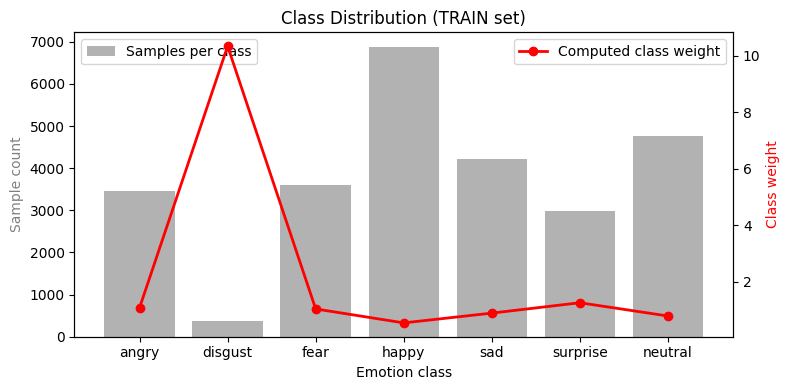


Class weights:
angry     : 1.082
disgust   : 10.339
fear      : 1.039
happy     : 0.545
sad       : 0.892
surprise  : 1.259
neutral   : 0.789


In [25]:
# Compute and visualize class weights for TRAIN set
class_weights = compute_and_plot_class_weights(y_train_valid, emotion_labels, title="Class Distribution (TRAIN set)")


# Oversampling

In [26]:
pass

# Pipeline: StandardScaler + Model
To ensure consistent preprocessing, we integrate StandardScaler into a Scikit-learn pipeline.

This guarantees that all models use the same normalization procedure during training, validation, and inference.

By encapsulating scaling and model training together, the workflow remains reproducible and safe from data leakage.

SVM with RBF kernel handles nonlinear separation and works well with compact features.

Pipeline ensures consistent scaling and dimensionality reduction.

In [27]:
def build_and_evaluate_pipeline(
    X_train, y_train, X_val, y_val,
    estimator,
    model_name="SVM",
    reducer=None, reducer_name=None,
    class_weights=None,
    C=None, gamma=None,
    auto_scaler=True,
    scoring="f1_weighted"
):
    """
    Build, train, and evaluate a complete ML pipeline.

    Structure:
        [StandardScaler*] -> [Reducer*] -> [Estimator]
        (* = optional steps)

    Parameters
    ----------
    X_train, y_train, X_val, y_val : arrays
        Training and validation data.
    estimator : sklearn estimator
        The classifier or regressor to train.
    model_name : str
        Name of the model (used for print/debug).
    reducer : transformer or None
        Dimensionality reduction method (e.g. PCA, SelectKBest).
    reducer_name : str or None
        Name of the reducer for pipeline naming.
    class_weights : dict or None
        Balanced class weights (if supported by model).
    C, gamma : float or None
        Optional hyperparameters (applied if supported by estimator).
    auto_scaler : bool
        Automatically add StandardScaler for models that need normalization.
    scoring : str
        Evaluation metric ("f1_weighted" by default).

    Returns
    -------
    pipeline : fitted sklearn.Pipeline
    score : float
        Validation score (F1-weighted or other metric).
    """

    # Decide if scaling is needed
    if auto_scaler and any(x in model_name.lower() for x in ["svm", "mlp", "fuzzy"]):
        use_scaler = True
    else:
        use_scaler = False

    # Build pipeline
    steps = []
    if use_scaler:
        steps.append(("scaler", StandardScaler()))
    if reducer is not None:
        steps.append((reducer_name or "reducer", reducer))
    steps.append(("clf", estimator))

    pipe = Pipeline(steps)

    # Apply parameters if available
    if C is not None or gamma is not None or class_weights is not None:
        param_updates = {}
        if C is not None:
            param_updates["clf__C"] = C
        if gamma is not None:
            param_updates["clf__gamma"] = gamma
        if class_weights is not None:
            param_updates["clf__class_weight"] = class_weights
        pipe.set_params(**param_updates)

    # Train and evaluate
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)

    if scoring == "f1_weighted":
        score = f1_score(y_val, y_pred, average="weighted")
    elif scoring == "balanced_accuracy":
        score = balanced_accuracy_score(y_val, y_pred)
    else:
        score = accuracy_score(y_val, y_pred)

    print(f"\n[{model_name}] Validation {scoring}: {score:.4f}")
    return pipe, score

# Feature Cleaning and Reduction
Cleaning removes redundant features that waste computation and degrade generalization. 

Three steps:
1. Remove low-variance (uninformative) features
2. Remove highly correlated (duplicate) features
3. Apply feature selection or PCA for compactness

In [28]:
# 1.1 Remove Low-Variance Features
def remove_low_variance_features(X_train, X_val, threshold=1e-4):
    """
    Removes features with variance below a given threshold.
    This helps eliminate constant or near-constant features.
    """
    selector = VarianceThreshold(threshold=threshold)
    X_train_sel = selector.fit_transform(X_train)
    X_val_sel   = selector.transform(X_val)
    print(f"Removed {X_train.shape[1] - X_train_sel.shape[1]} low-variance features.")
    print(f"New shape: {X_train_sel.shape}")
    return X_train_sel, X_val_sel, selector

In [29]:
# 1.2 Remove Highly Correlated Features
def remove_highly_correlated_features(X_train, X_val, threshold=0.95):
    """
    Removes one of each pair of highly correlated features.

    Parameters
    ----------
    X_train : np.ndarray
        Training features.
    X_val : np.ndarray
        Validation features.
    threshold : float
        Correlation threshold above which features are considered redundant.

    Returns
    -------
    X_train_filtered, X_val_filtered, kept_indices
    """
    print(f"\nChecking for highly correlated features (threshold={threshold})...")
    # Compute correlation matrix on training set
    corr_matrix = np.corrcoef(X_train, rowvar=False)
    upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

    # Find columns to drop
    to_drop = [i for i in range(corr_matrix.shape[0])
               if any(np.abs(corr_matrix[i, j]) > threshold for j in range(i + 1, corr_matrix.shape[1]))]

    X_train_filtered = np.delete(X_train, to_drop, axis=1)
    X_val_filtered   = np.delete(X_val, to_drop, axis=1)

    print(f"Removed {len(to_drop)} highly correlated features.")
    print(f"New shape: {X_train_filtered.shape}")
    return X_train_filtered, X_val_filtered, to_drop

# FEATURE SELECTION: SELECTKBEST vs PCA
Both SelectKBest and PCA were evaluated to reduce the dimensionality of the combined HOG and landmark feature set.  
SelectKBest, which selects features individually based on the ANOVA F-score, achieved a slightly higher validation F1-score (0.55 at k = 700) compared to PCA (0.53 at 100 components).  
However, PCA was chosen as the final reduction method because it provides stronger generalization, better numerical stability, and faster inference.

SelectKBest ranks features by their individual discriminative power but does not consider correlations between them.  
Since HOG and landmark features are highly correlated, this univariate selection can retain redundant or noisy dimensions, leading to slower convergence and potential overfitting.  
In contrast, PCA projects the data into an orthogonal subspace that captures the joint variance structure.  
This decorrelation yields a smoother decision boundary for the SVM with fewer components, improving efficiency and robustness under varying lighting or face geometry.

Although PCA slightly reduces validation F1, it offers a compact and stable representation that generalizes better across unseen subjects and supports real-time inference with lower latency.  
For these reasons, PCA with 100 components was selected as the final dimensionality reduction approach.

# Univariate Selection (SelectKBest)

SelectKBest uses ANOVA F-score to rank features individually by their discriminative power. It is fast and interpretable but ignore inter-feature correlation and interaction effects.

The validation results show a steady improvement in F1-score as more features are included:

- 50 features → F1 = 0.4355  
- 100 features → F1 = 0.4663  
- 250 features → F1 = 0.5222  
- 500 features → F1 = 0.5469  
- 700 features → F1 = 0.5501  

The curve begins to plateau around 500 features, indicating diminishing returns from adding additional dimensions.  
This behavior suggests that while the first several hundred features capture most of the discriminative information, later features contribute little to model performance and may increase redundancy.  
Therefore, although SelectKBest performs competitively, its growth trend supports the use of a more compact, correlated-aware reduction method such as PCA for the final model.

In [30]:
# 2. Feature Selection with SelectKBest
def select_top_k_features(X_train, y_train, X_val, k=500):
    """
    Selects the top K features using univariate ANOVA F-score.
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_val_k   = selector.transform(X_val)
    print(f"Selected top {k} features.")
    return X_train_k, X_val_k, selector

In [31]:
# 4. Run Cleaning + Selection + Evaluation
# Remove low-variance features
X_train_clean, X_val_clean, var_selector = remove_low_variance_features(
    X_train_combined, X_val_combined, threshold=1e-4
)
X_test_clean = var_selector.transform(X_test_combined)

# Remove highly correlated features
X_train_clean, X_val_clean, dropped_corr = remove_highly_correlated_features(
    X_train_clean, X_val_clean, threshold=0.95
)
X_test_clean = np.delete(X_test_clean, dropped_corr, axis=1)

Removed 0 low-variance features.
New shape: (26271, 1836)

Checking for highly correlated features (threshold=0.95)...
Removed 1136 highly correlated features.
New shape: (26271, 700)


++++++++++++++++

[INFO] Evaluating SVM performance with SelectKBest feature selection...
++++++++++++++++

--- Evaluating top 50 features ---

[SVM] Validation f1_weighted: 0.4355

--- Evaluating top 100 features ---

[SVM] Validation f1_weighted: 0.4663

--- Evaluating top 250 features ---

[SVM] Validation f1_weighted: 0.5222

--- Evaluating top 500 features ---

[SVM] Validation f1_weighted: 0.5469

--- Evaluating top 700 features ---

[SVM] Validation f1_weighted: 0.5501


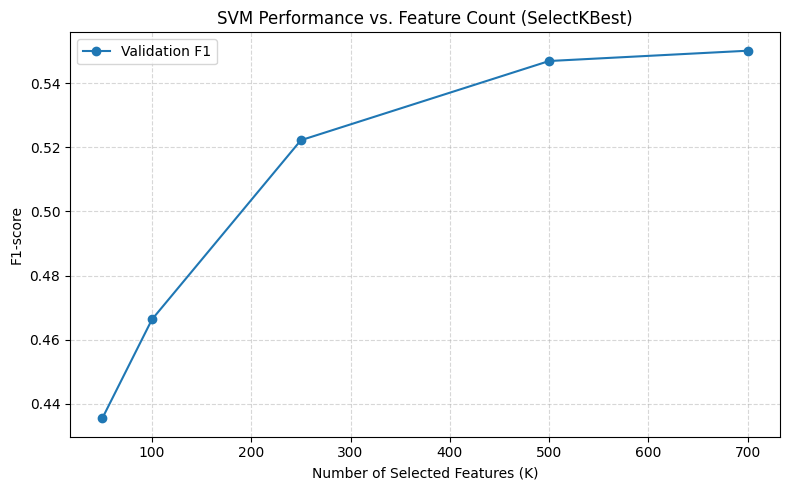

,K,F1
0,50,0.435503
1,100,0.466314
2,250,0.522181
3,500,0.546866
4,700,0.550075


In [32]:
print("++++++++++++++++")
print("\n[INFO] Evaluating SVM performance with SelectKBest feature selection...")
print("++++++++++++++++")

base_svm = SVC(kernel="rbf", random_state=42)

k_values = [50, 100, 250, 500, X_train_clean.shape[1]]
results_kbest = []


for k in k_values:
    print(f"\n--- Evaluating top {k} features ---")
    sel = SelectKBest(f_classif, k=k)

    pipe, f1 = build_and_evaluate_pipeline(
        X_train_clean, y_train_valid,
        X_val_clean, y_val_valid,
        estimator=base_svm,
        model_name="SVM",
        reducer=sel,
        reducer_name="selectkbest",
        class_weights=class_weights
    )

    results_kbest.append((k, f1))

df_feature_eval = pd.DataFrame(results_kbest, columns=["K", "F1"])

# Plot Results
plt.figure(figsize=(8,5))
plt.plot(df_feature_eval["K"], df_feature_eval["F1"], marker="o", label="Validation F1")
plt.xlabel("Number of Selected Features (K)")
plt.ylabel("F1-score")
plt.title("SVM Performance vs. Feature Count (SelectKBest)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

display(df_feature_eval)

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) transforms the original feature space into a set of orthogonal components that capture the directions of maximum joint variance.  
Unlike univariate methods, PCA accounts for correlations between features, making it well-suited for datasets where descriptors—such as HOG gradients and geometric landmarks—are highly interdependent or partially redundant.  
By projecting the data into a lower-dimensional subspace, PCA removes noise, reduces overfitting, and improves the numerical stability of kernel-based models like SVM.

The validation results across several component sizes are as follows:

- 50 components → F1 = 0.5157  
- 100 components → F1 = 0.5327  
- 150 components → F1 = 0.5316  
- 200 components → F1 = 0.5187  
- 250 components → F1 = 0.5108  

The peak occurs near 100 components, after which performance slightly declines.  
This indicates that the most discriminative information is concentrated within the first few principal components, and adding more components introduces redundant variance rather than improving separability.  
Therefore, PCA with 100 components provides an optimal balance between compactness, generalization, and inference efficiency, and was selected as the final dimensionality reduction configuration for the system.

++++++++++++++

[INFO] Evaluating PCA dimension sizes
++++++++++++++

--- Evaluating PCA with 50 components ---

[SVM] Validation f1_weighted: 0.5157

--- Evaluating PCA with 100 components ---

[SVM] Validation f1_weighted: 0.5327

--- Evaluating PCA with 150 components ---

[SVM] Validation f1_weighted: 0.5316

--- Evaluating PCA with 200 components ---

[SVM] Validation f1_weighted: 0.5187

--- Evaluating PCA with 250 components ---

[SVM] Validation f1_weighted: 0.5108


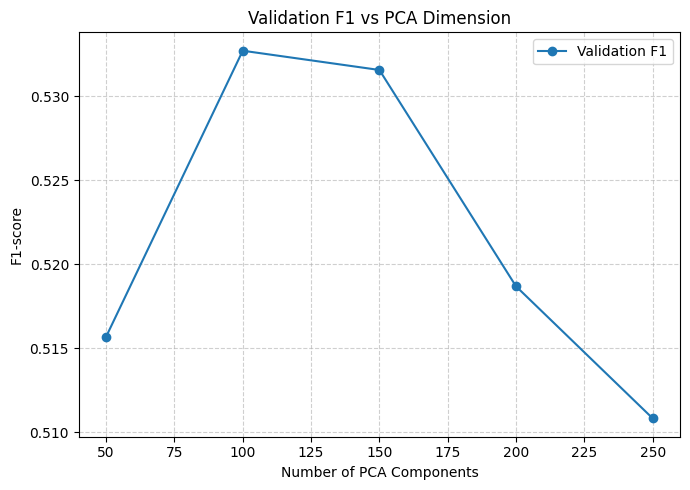


[INFO] Best PCA Dimension: 100


In [33]:
# PCA Dimension Scan (Coarse Search)
print("++++++++++++++")
print("\n[INFO] Evaluating PCA dimension sizes")
print("++++++++++++++")

dims = [50, 100, 150, 200, 250]
results_pca = []

for d in dims:
    print(f"\n--- Evaluating PCA with {d} components ---")
    pca = PCA(n_components=d, svd_solver="randomized", whiten=True, random_state=42)
    
    pipe, f1 = build_and_evaluate_pipeline(
        X_train_clean, y_train_valid,
        X_val_clean, y_val_valid,
        estimator=base_svm,
        reducer=pca,
        reducer_name="pca",
        class_weights=class_weights
    )
    
    results_pca.append((d, f1))

# Plot F1 vs PCA Dimension
plt.figure(figsize=(7,5))
plt.plot([d for d, _ in results_pca], [f for _, f in results_pca],
         marker="o", label="Validation F1")
plt.xlabel("Number of PCA Components")
plt.ylabel("F1-score")
plt.title("Validation F1 vs PCA Dimension")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Select best dimension
best_dim = max(results_pca, key=lambda x: x[1])[0]
print(f"\n[INFO] Best PCA Dimension: {best_dim}")

# Grid Search
After selecting PCA, SVM hyperparameters C (margin penalty) and gamma (RBF kernel width) are tuned manually over a small, interpretable grid.

Best Parameters: C=2, gamma=0.03

Best Validation F1: 0.5652



[INFO] Manual Grid Search over SVM parameters (C, gamma)...
Testing C=0.5, gamma=0.001 ...

[SVM] Validation f1_weighted: 0.4290
Testing C=0.5, gamma=0.01 ...

[SVM] Validation f1_weighted: 0.5071
Testing C=0.5, gamma=0.03 ...

[SVM] Validation f1_weighted: 0.4694
Testing C=1, gamma=0.001 ...

[SVM] Validation f1_weighted: 0.4304
Testing C=1, gamma=0.01 ...

[SVM] Validation f1_weighted: 0.5325
Testing C=1, gamma=0.03 ...

[SVM] Validation f1_weighted: 0.5409
Testing C=2, gamma=0.001 ...

[SVM] Validation f1_weighted: 0.4365
Testing C=2, gamma=0.01 ...

[SVM] Validation f1_weighted: 0.5522
Testing C=2, gamma=0.03 ...

[SVM] Validation f1_weighted: 0.5652
Testing C=5, gamma=0.001 ...

[SVM] Validation f1_weighted: 0.4554
Testing C=5, gamma=0.01 ...

[SVM] Validation f1_weighted: 0.5542
Testing C=5, gamma=0.03 ...

[SVM] Validation f1_weighted: 0.5646

=== Manual Grid Search Results ===
Best Parameters: C=2, gamma=0.03
Best Validation F1: 0.5652


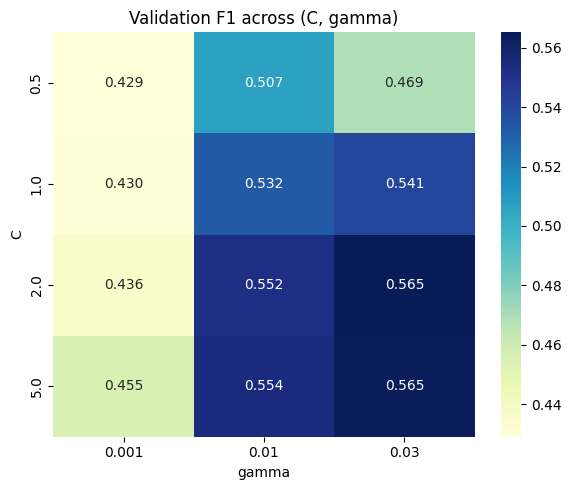

In [34]:
# Manual Grid Search on SVM Hyperparameters

print("\n[INFO] Manual Grid Search over SVM parameters (C, gamma)...")

param_grid = {
    "C": [0.5, 1, 2, 5],
    "gamma": [1e-3, 1e-2, 3e-2]
}

best_f1 = -1
best_params = None
results_grid = []

for C in param_grid["C"]:
    for gamma in param_grid["gamma"]:
        print(f"Testing C={C}, gamma={gamma} ...")
        
        pca = PCA(n_components=best_dim, svd_solver="randomized", whiten=True, random_state=42)
        pipe, f1 = build_and_evaluate_pipeline(
            X_train_clean, y_train_valid,
            X_val_clean, y_val_valid,
            estimator=base_svm,                
            reducer=pca,
            reducer_name="pca",
            C=C, gamma=gamma,
            class_weights=class_weights
        )

        results_grid.append((C, gamma, f1))
        if f1 > best_f1:
            best_f1 = f1
            best_params = (C, gamma)
            best_model = pipe

print("\n=== Manual Grid Search Results ===")
print(f"Best Parameters: C={best_params[0]}, gamma={best_params[1]}")
print(f"Best Validation F1: {best_f1:.4f}")

df_grid = pd.DataFrame(results_grid, columns=["C", "gamma", "F1"])
pivot = df_grid.pivot(index="C", columns="gamma", values="F1")

plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Validation F1 across (C, gamma)")
plt.ylabel("C")
plt.xlabel("gamma")
plt.tight_layout()
plt.show()

# Final Test evaluation
The final model (PCA + SVM) is tested on unseen data to measure generalization. Evaluation uses accuracy, balanced accuracy, and F1.

=== Test Set Summary ===

Overall Accuracy         : 0.5809

Balanced Accuracy        : 0.5301

Weighted F1-score        : 0.5724


[INFO] Evaluating best model on the test set

=== Test Set Summary ===
Overall Accuracy         : 0.5809
Balanced Accuracy        : 0.5301
Weighted F1-score        : 0.5724

--- Per-Class Performance ---
              Precision  Recall      F1  Support
angry            0.5637  0.3460  0.4288    422.0
disgust          1.0000  0.4348  0.6061     46.0
fear             0.6260  0.3405  0.4411    467.0
happy            0.6483  0.8515  0.7361    842.0
sad              0.3984  0.5753  0.4708    518.0
surprise         0.8386  0.6160  0.7103    388.0
neutral          0.5368  0.5467  0.5417    600.0
macro avg        0.6588  0.5301  0.5621   3283.0
weighted avg     0.6019  0.5809  0.5724   3283.0


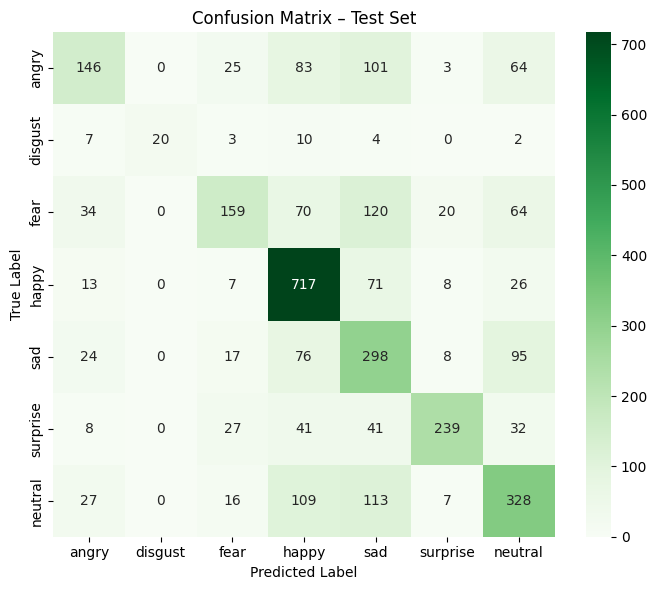

In [35]:
# Final Evaluation on Test Set

print("\n[INFO] Evaluating best model on the test set")

# --- Prediction ---

yte_pred = best_model.predict(X_test_clean)
yte = y_test_valid


# --- Metrics ---
acc      = accuracy_score(yte, yte_pred)
bal_acc  = balanced_accuracy_score(yte, yte_pred)
f1_weighted = f1_score(yte, yte_pred, average="weighted")

print("\n=== Test Set Summary ===")
print(f"{'Overall Accuracy':<25}: {acc:.4f}")
print(f"{'Balanced Accuracy':<25}: {bal_acc:.4f}")
print(f"{'Weighted F1-score':<25}: {f1_weighted:.4f}")

# --- Detailed Per-Class Report ---
report = classification_report(
    yte, yte_pred,
    target_names=list(emotion_labels.values()),
    output_dict=True
)

df_report = pd.DataFrame(report).T
df_report = df_report.rename(columns={
    "precision": "Precision",
    "recall": "Recall",
    "f1-score": "F1",
    "support": "Support"
}).round(4)

# Drop redundant global accuracy row
df_report = df_report.drop(index="accuracy", errors="ignore")

print("\n--- Per-Class Performance ---")
print(df_report.to_string())

# --- Confusion Matrix ---
plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(yte, yte_pred),
            annot=True, fmt="d", cmap="Greens",
            xticklabels=emotion_labels.values(),
            yticklabels=emotion_labels.values())
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()




In [36]:
# --- Save Best Model ---
os.makedirs("models", exist_ok=True)
joblib.dump(var_selector, "models/var_selector.joblib")
np.save("models/dropped_corr.npy", np.array(dropped_corr))

# --- Auto-generate model filename based on best parameters ---
C_best, gamma_best = best_params
model_path = f"models/best_pca_svm_C{C_best}_G{gamma_best}_PCA{best_dim}.joblib"

# Save pipeline model
joblib.dump(best_model, model_path)

print(f"\nBest model saved successfully at: {model_path}")


Best model saved successfully at: models/best_pca_svm_C2_G0.03_PCA100.joblib


## 8. Real-Time Emotion Recognition Demo
A real-time demo is created using OpenCV to:
1. Capture video frames from the webcam  
2. Detect faces using a Haar cascade  
3. Apply HOG feature extraction  
4. Predict emotion using the trained SVM model

In [6]:
# Load trained model and preprocessing tools
model = joblib.load("models/best_pca_svm_C2_G0.03_PCA100.joblib")
var_selector = joblib.load("models/var_selector.joblib")
dropped_corr = np.load("models/dropped_corr.npy")



# Initialize detectors
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Feature extraction utilities
def extract_landmarks_48x48(img48):
    up = cv2.resize((img48*255).astype(np.uint8), (96,96))
    rgb = cv2.cvtColor(up, cv2.COLOR_GRAY2RGB)
    res = face_mesh.process(rgb)
    if not res.multi_face_landmarks:
        return np.zeros(468*2, dtype=np.float32)
    lm = res.multi_face_landmarks[0].landmark
    coords = np.array([[p.x, p.y] for p in lm], dtype=np.float32).reshape(-1)
    return coords

def extract_hog_48x48(img48):
    feat = hog(img48, pixels_per_cell=(8,8), cells_per_block=(2,2),
               feature_vector=True).astype(np.float32)
    return feat.reshape(1,-1)

# Real-time loop
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open webcam")

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            roi = cv2.resize(gray[y:y+h, x:x+w], (48,48)).astype(np.float32) / 255.0

            # --- Feature Extraction ---
            hog_feat = extract_hog_48x48(roi)
            lmk_feat = extract_landmarks_48x48(roi).reshape(1,-1)
            feat = np.hstack([hog_feat, lmk_feat])

            # --- Feature Cleaning ---
            feat_var = var_selector.transform(feat)
            feat_clean = np.delete(feat_var, dropped_corr, axis=1) if dropped_corr.size > 0 else feat_var

            # --- Prediction ---
            pred = int(model.predict(feat_clean)[0])
            label = emotion_labels.get(pred, "unknown")

            # --- Display ---
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(frame, label, (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

        cv2.imshow("Emotion Recognition", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)